In [2]:
# import Section
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from os import listdir
from os.path import isfile, join, isdir
import re
from matplotlib import pyplot as plt
import seaborn as sns
import glob
import re
from scipy.interpolate import interp1d

In [3]:
# Function Section
def calculate_pad(brightness, saturation):
    p = 0.69*brightness + 0.22*saturation
    a = -0.31*brightness + 0.6*saturation
    d = 0.76*brightness + 0.32*saturation
    return [p,d,a]
    
def calculate_blur(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

def mean_brightness(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #convert it to hsv
    return np.mean(hsv[:,:,2])

def mean_saturation(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #convert it to hsv
    return np.mean(hsv[:,:,1])

def calculate_opticalFlow(img1, img2):
    f, axarr = plt.subplots(2,1)
    axarr[0].imshow(img1)
    axarr[1].imshow(img2)
    plt.show()
    prev = cv2.cvtColor(testEld[0], cv2.COLOR_BGR2GRAY)
    forward = cv2.cvtColor(testEld[1], cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(prev)
    mask[..., 1] = 255
    flow = cv2.calcOpticalFlowFarneback(prev, forward, flow=None, pyr_scale=0.5,levels =1,winsize=3,iterations=15,poly_n=3,poly_sigma=5,flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    return cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)[0]

def isjpg(filepath):
    return re.search(".jpg$", filepath)

In [4]:
# constant
base = 'data//scenes'
movies = [x for x in listdir(base) if isdir(join(base, x)) and x != 'incredibles_example']
movies_paths = [join(base, x) for x in movies]
display(movies)
display(movies_paths)
img_paths = {}
for i in range(len(movies)):
    movie = movies[i]
    movie_path = movies_paths[i]
    files = [f for f in listdir(movie_path) if isjpg(join(movie_path, f))]
    img_paths[movie] = files
display([len(x) for x in img_paths.values()])

['big_hero_6', 'cars_3', 'incredible_2', 'toy_story_4', 'up', 'wall_e_']

['data//scenes\\big_hero_6',
 'data//scenes\\cars_3',
 'data//scenes\\incredible_2',
 'data//scenes\\toy_story_4',
 'data//scenes\\up',
 'data//scenes\\wall_e_']

[90, 90, 90, 91, 90, 90]

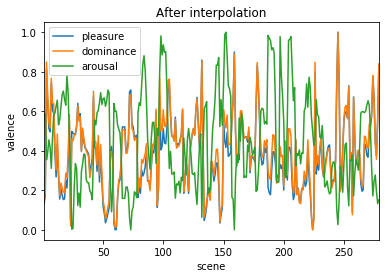

In [43]:
mypath = "data/scenes/incredibles_example"
files = [f for f in listdir(mypath) if isjpg(join(mypath, f))]
pad_data = []                                                                                                                                                  
for fname in files:
    src = cv2.imread(join(mypath, fname),1)                                                    
    if(src is None):                                                            
        continue
    gx = '^[^-]*-([^-]*).*'
    p = re.compile(gx)
    scene = int(p.search(fname.replace('incredibles-','')).group(1))
    pad_data.append(calculate_pad(mean_brightness(src),mean_saturation(src)) + [scene])


df = pd.DataFrame(pad_data,columns=['pleasure','dominance','arousal', 'scene'] )
df = df.sort_values(by=['scene'],ascending=True)
df = df.groupby(['scene']).mean()
normalized_df=(df-df.min())/(df.max()-df.min())
normalized_df

ax2 = normalized_df.plot.line()
ax2.set_title('After interpolation')
ax2.set_xlabel("scene")
ax2.set_ylabel("valence")
normalized_df = normalized_df.reset_index()

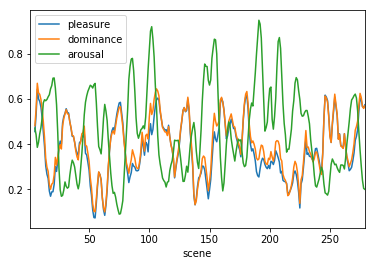

In [44]:
normalized_df.rolling(5, on='scene').mean().plot(x='scene',style='-')

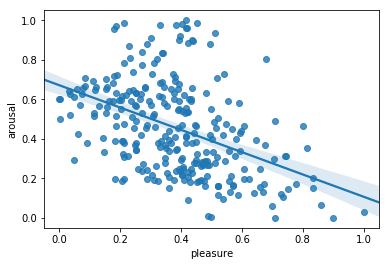

In [12]:
sns.regplot(normalized_df['pleasure'],normalized_df['arousal'])

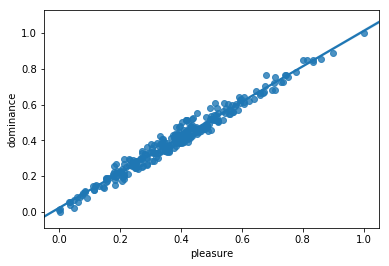

In [13]:
sns.regplot(normalized_df['pleasure'],normalized_df['dominance'])

In [14]:
new_df = normalized_df.copy()
new_df['pleasure_diff'] = new_df['pleasure'].diff(-1)
new_df['pleasure_inflection'] = np.where(new_df['pleasure_diff'] > 0, 1, 0)
new_df[new_df['pleasure_inflection'].diff() != 0]['scene']

0        1
2        3
5        6
6        7
10      11
11      12
13      14
14      15
16      17
18      19
19      20
21      22
22      23
23      24
26      27
28      29
29      30
30      31
31      32
32      33
38      39
41      42
44      45
45      46
46      47
47      48
51      52
56      57
59      60
67      68
      ... 
216    217
217    218
219    220
223    224
225    226
226    227
227    228
228    229
230    231
232    233
237    238
239    240
240    241
241    242
244    245
246    247
251    252
252    253
253    254
254    255
255    256
256    257
257    258
259    260
261    262
264    265
266    267
269    270
273    274
276    277
Name: scene, Length: 141, dtype: int64

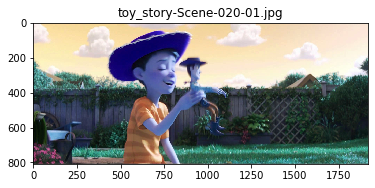

In [47]:
mypath = "data/scenes/toy_story_4"
onlyfiles = [f for f in listdir(mypath) if isjpg(join(mypath, f))]
i = 0
ans={}
testEld = []
index = []

if i < len(onlyfiles) - 1:
    test = cv2.imread(join(mypath, onlyfiles[i]))
    test_next = cv2.imread(join(mypath, onlyfiles[i+1]))

    testEld.append(test)
    testEld.append(test_next)
    plt.imshow(test)
    title = onlyfiles[i]
    plt.title(f"{title}")
    plt.show()
    i+=1

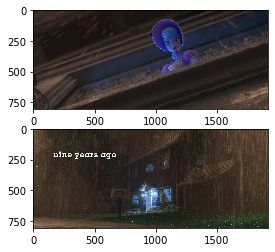

array([2.5923033e-10, 6.3751258e-08, 1.4817554e-05, ..., 2.0641835e-05,
       1.4722971e-07, 5.2004651e-10], dtype=float32)

In [8]:
calculate_opticalFlow(test, test_next)

In [4]:
# Model

In [5]:
# Evaluation